In [140]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import matplotlib.patches as mpatches

import requests


In [141]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [142]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

# Tests

## Processing

In [143]:
tests = requests.get("https://covidtracking.com/api/states/daily").json()
tests_df = pd.DataFrame(tests)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200408,AK,226.0,6842.0,NaN,NaN,27.0,NaN,NaN,NaN,...,27.0,7068,7068,7068,02,1.0,4.0,142.0,13.0,155.0
1,20200408,AL,2369.0,16753.0,NaN,NaN,314.0,NaN,NaN,NaN,...,314.0,19122,19122,19122,01,10.0,43.0,3956.0,250.0,4206.0
2,20200408,AR,1000.0,13530.0,NaN,76.0,130.0,NaN,43.0,30.0,...,130.0,14530,14530,14530,05,2.0,-18.0,838.0,54.0,892.0
3,20200408,AS,0.0,20.0,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,31,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200408,AZ,2726.0,31838.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,34564,34564,34564,04,7.0,0.0,1038.0,151.0,1189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,20200302,WA,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,34,34,34,53,3.0,0.0,0.0,4.0,4.0
1884,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,44,NaN,NaN,NaN,NaN,NaN
1885,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30,30,30,53,3.0,0.0,0.0,12.0,12.0
1886,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18,18,18,53,1.0,0.0,0.0,9.0,9.0


In [144]:
tests_df['dateChecked'] = pd.to_datetime(tests_df['dateChecked'])
tests_df['Date'] = pd.to_datetime(tests_df['dateChecked'].dt.date)

In [145]:
tests_df[['positive', 'negative', 'pending', 'death', 'total']] = tests_df[['positive', 'negative', 'pending', 'death', 'total']].astype(int, errors='ignore')

In [146]:
tests_df['completed'] = tests_df['positive'] + tests_df['negative']

In [147]:
%store tests_df

Stored 'tests_df' (DataFrame)


## Analysis

In [148]:
tests_df.groupby('Date')['completed'].sum().max()

2197743.0

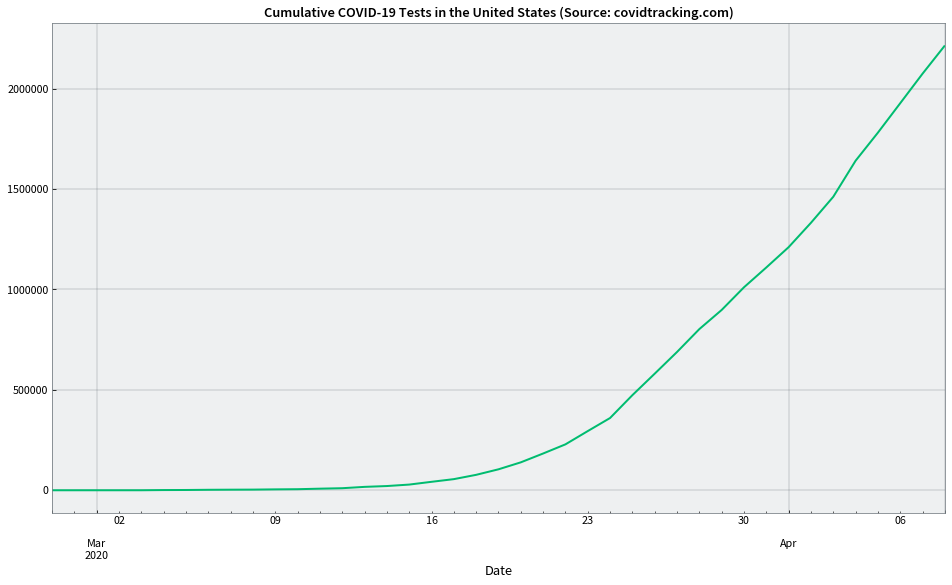

In [149]:
tests_df.groupby('Date')['total'].sum().plot(kind='line', 
                                                    title="Cumulative COVID-19 Tests in the United States (Source: covidtracking.com)")

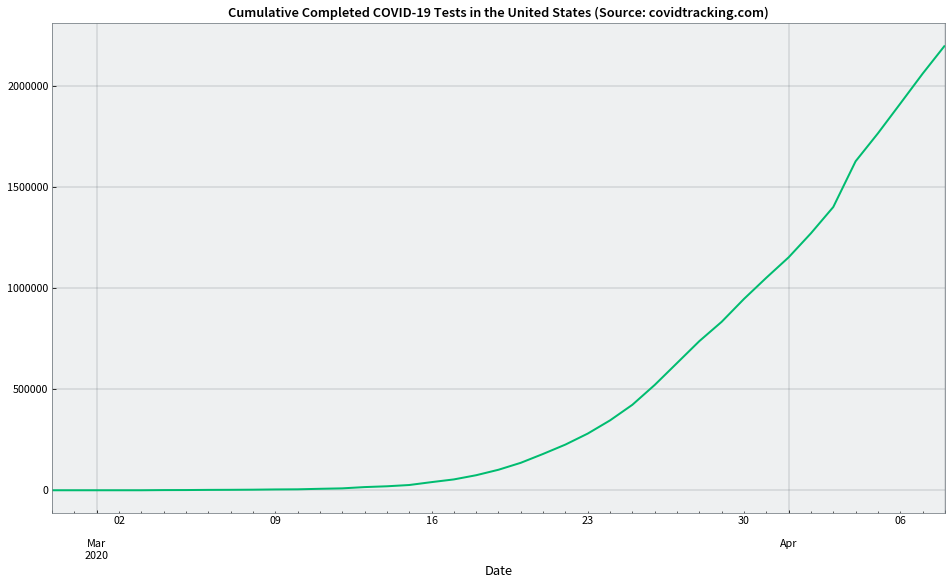

In [150]:
tests_df.groupby('Date')['completed'].sum().plot(kind='line', 
                                                    title="Cumulative Completed COVID-19 Tests in the United States (Source: covidtracking.com)")

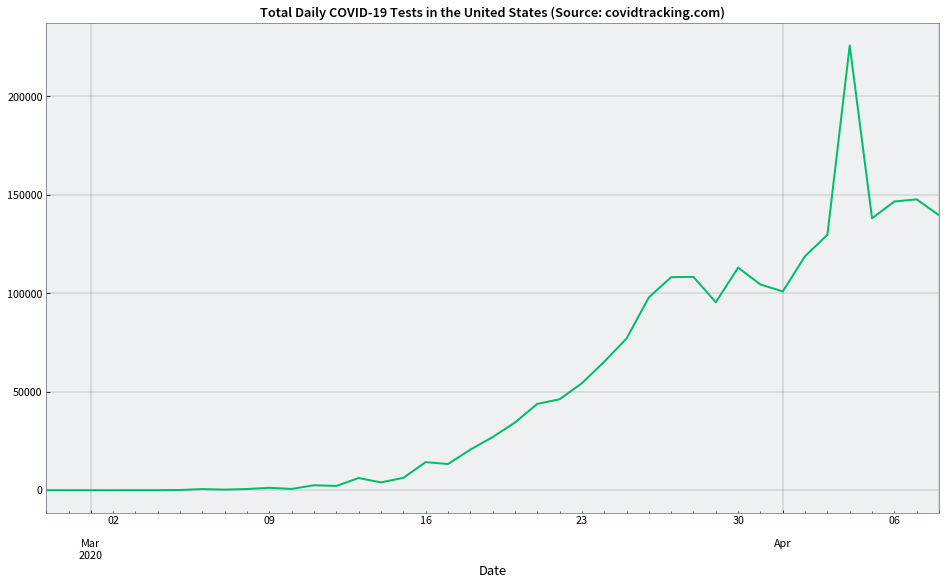

In [151]:
tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', 
                                                    title="Total Daily COVID-19 Tests in the United States (Source: covidtracking.com)")

In [152]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

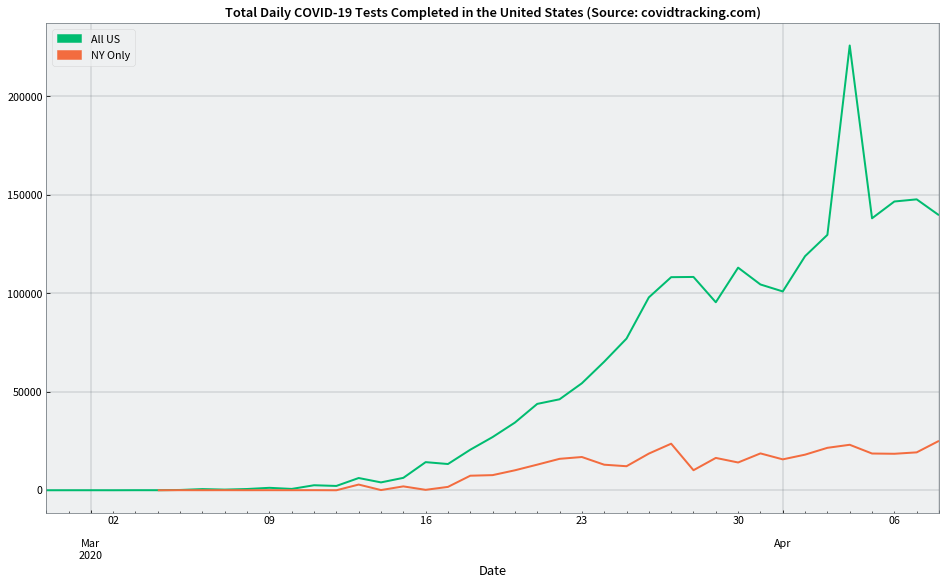

In [153]:
figsize(16, 9)
ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', label="US",
                                                    title="Total Daily COVID-19 Tests Completed in the United States (Source: covidtracking.com)")

tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line', ax=ax)

ax.legend(handles=[mpatches.Patch(color="#00bc70", label="All US"),
                   mpatches.Patch(color="#f36c3f", label="NY Only")])

In [154]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('Date')['total'].sum().diff().mean()

120017.0

In [155]:
tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-23')].groupby('Date')['total'].sum().diff().mean()

17929.0

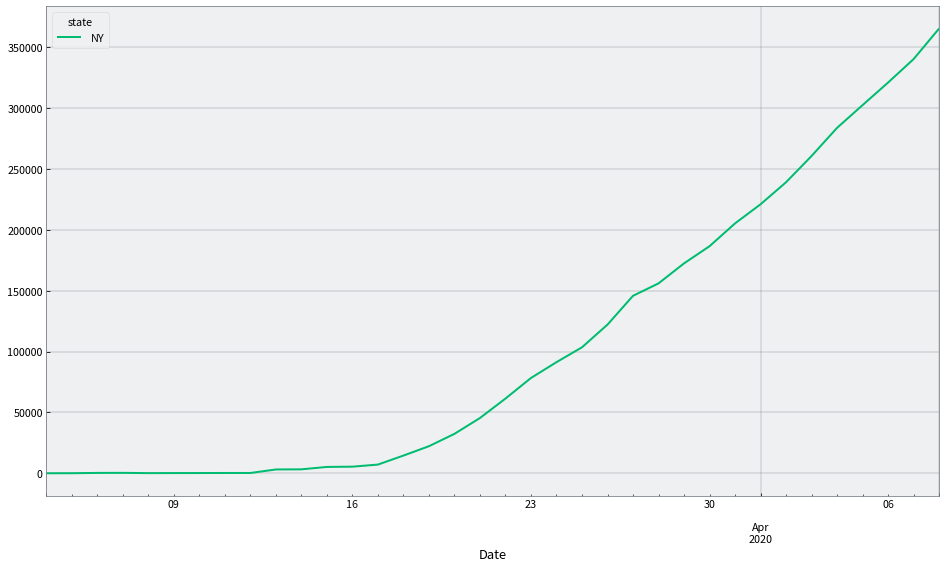

In [156]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line')

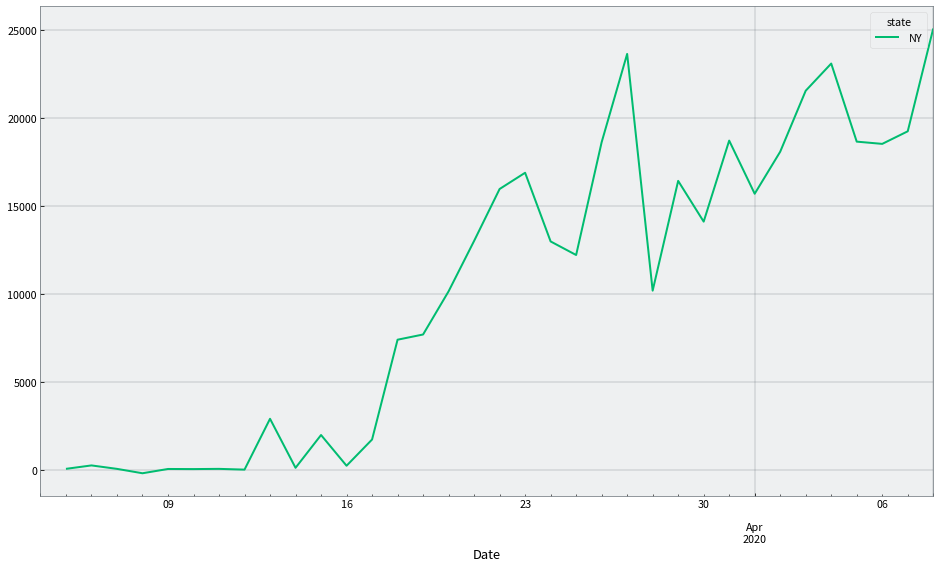

In [157]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line')

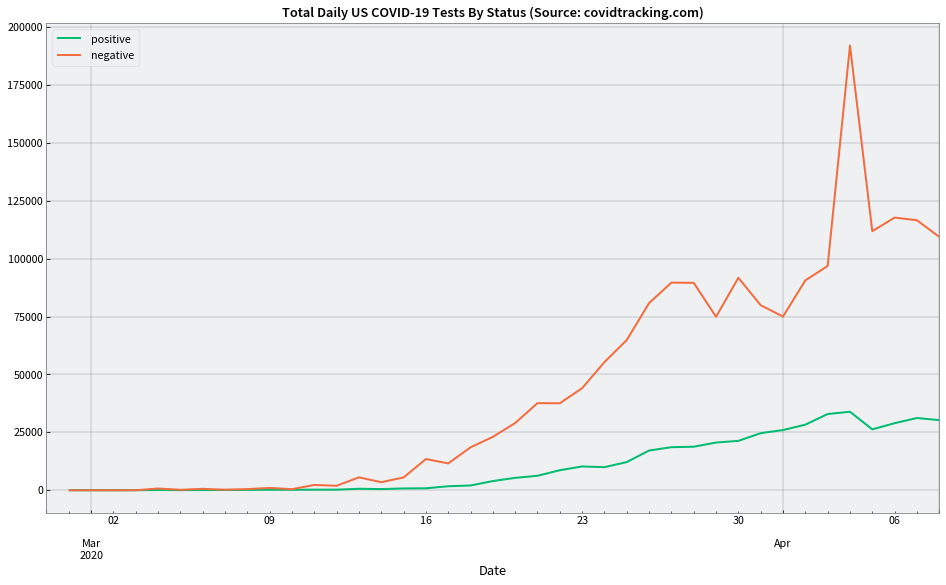

In [158]:
tests_df.groupby('Date')[['positive', 'negative']].sum().diff().plot(kind='line', 
                                                                     title="Total Daily US COVID-19 Tests By Status (Source: covidtracking.com)")

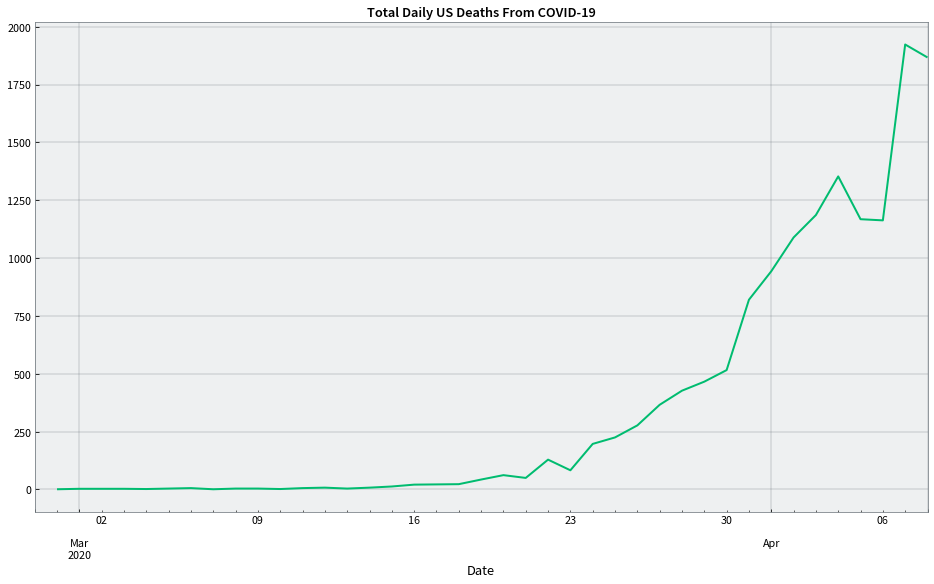

In [159]:
tests_df.groupby('Date')['death'].sum().diff().plot(kind='line',
                                                    title="Total Daily US Deaths From COVID-19")

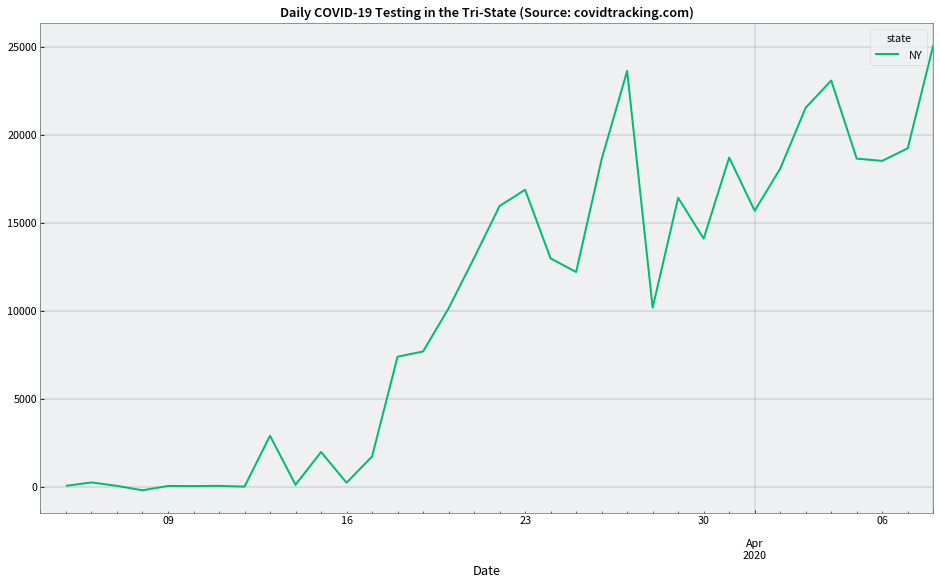

In [160]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

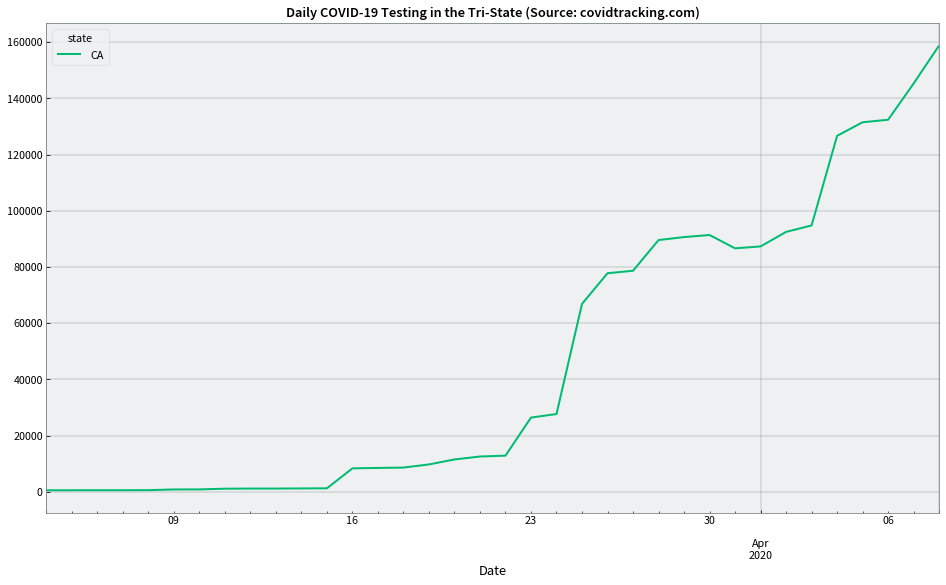

In [161]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['total'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

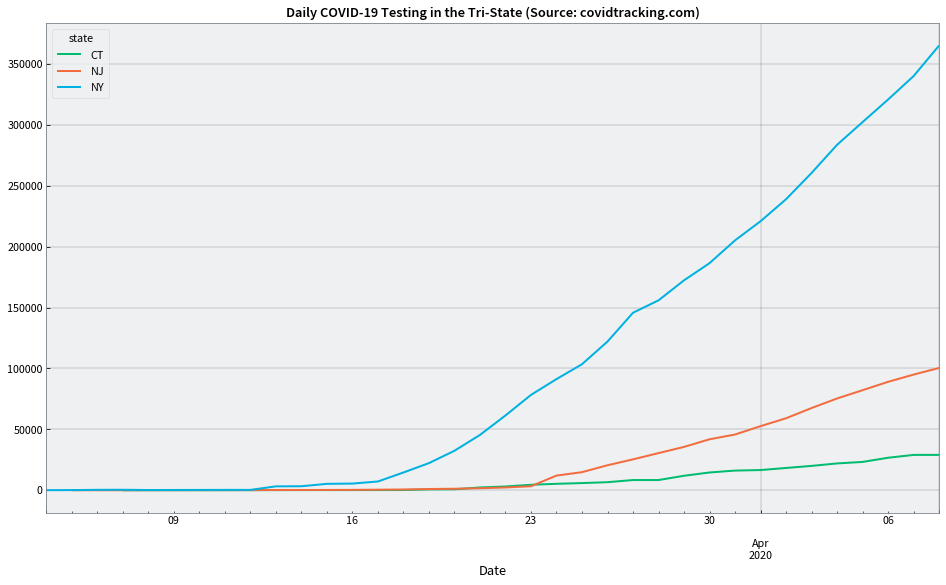

In [162]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'CT', 'NJ'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

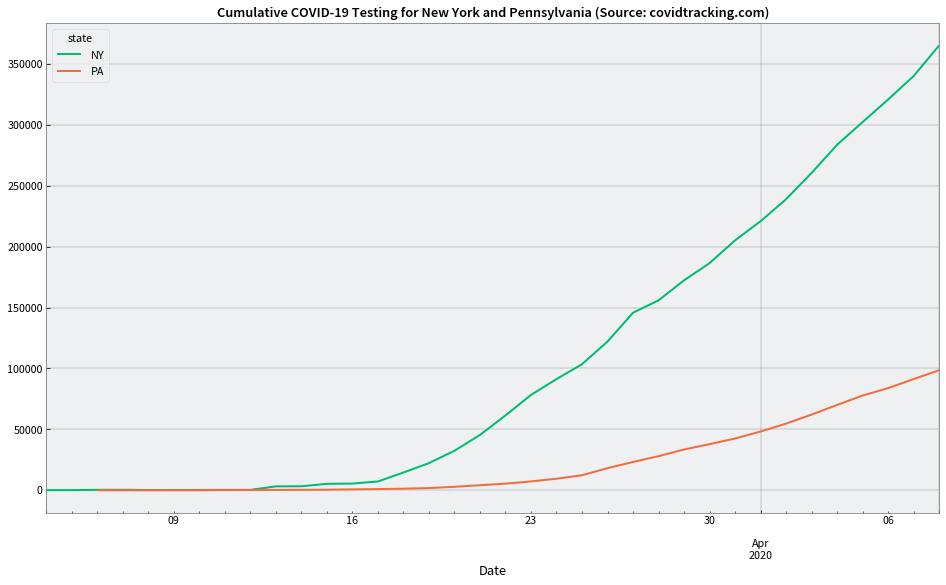

In [163]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'PA'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Pennsylvania (Source: covidtracking.com)")

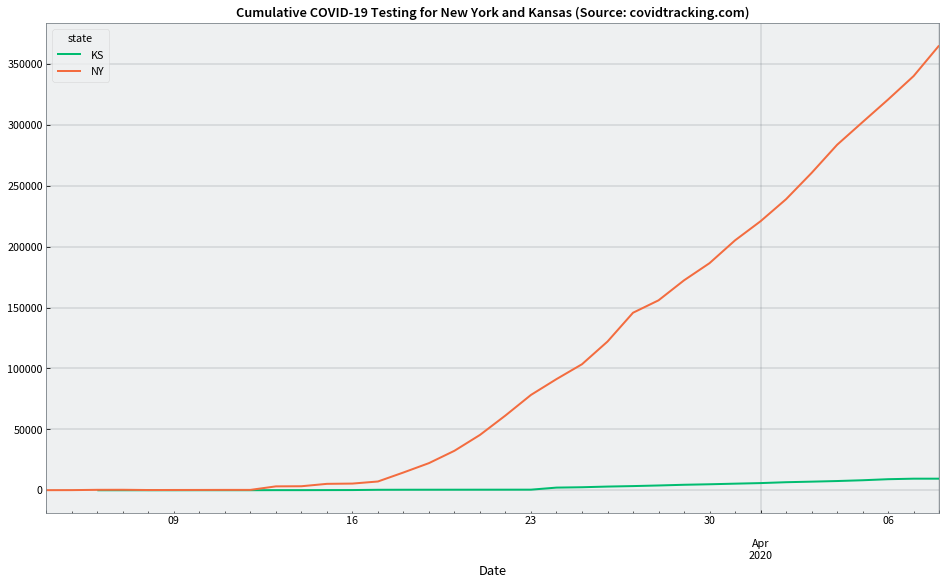

In [164]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Kansas (Source: covidtracking.com)")

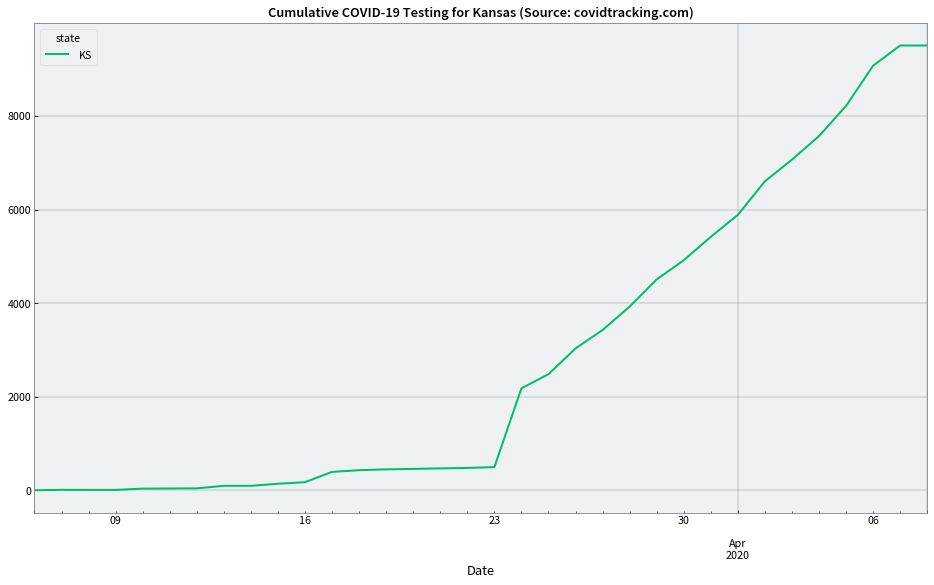

In [165]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

In [166]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

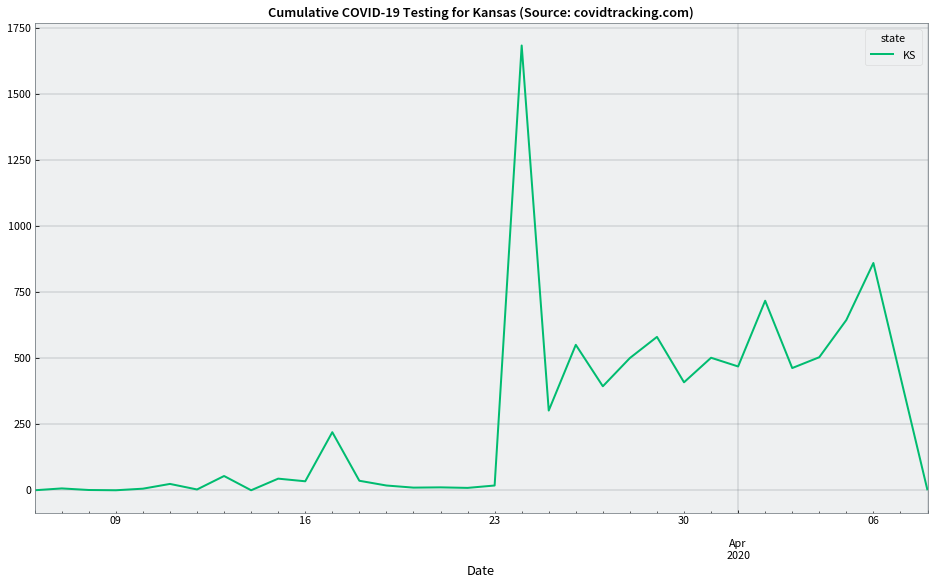

In [167]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

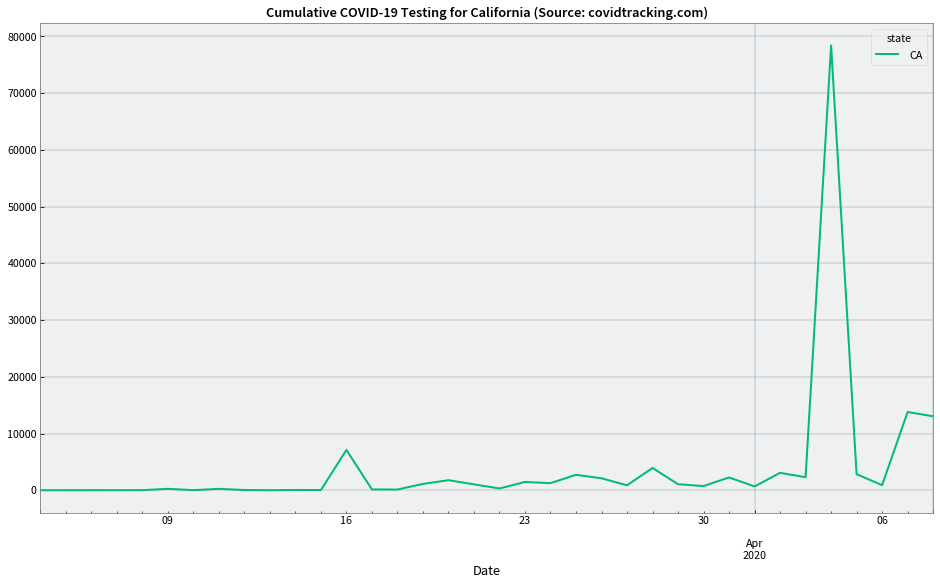

In [168]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for California (Source: covidtracking.com)")

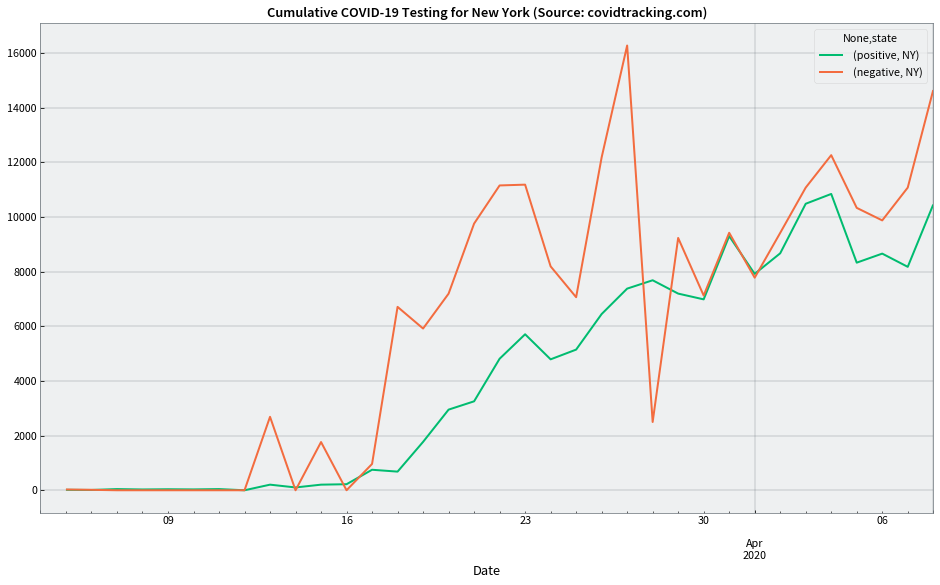

In [169]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])[['positive', 'negative']].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York (Source: covidtracking.com)")

In [170]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

In [171]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100)

Date
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-07         NaN
2020-03-08         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12         NaN
2020-03-13         NaN
2020-03-14         NaN
2020-03-15         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
2020-03-21    3.527962
2020-03-22    3.214931
2020-03-23    3.365735
2020-03-24    3.543333
2020-03-25    3.677075
2020-03-26    5.605058
2020-03-27    5.849622
2020-03-28    6.447600
2020-03-29    7.005686
2020-03-30    7.358367
2020-03-31    7.751016
2020-04-01    8.315828
2020-04-02    8.711318
2020-04-03    9.095655
2020-04-04    9.302203
2020-04-05    9.293370
2020-04-06    9.414577
2020-04-07    9.434567
2020-04-08    8.946661
dtype: float64

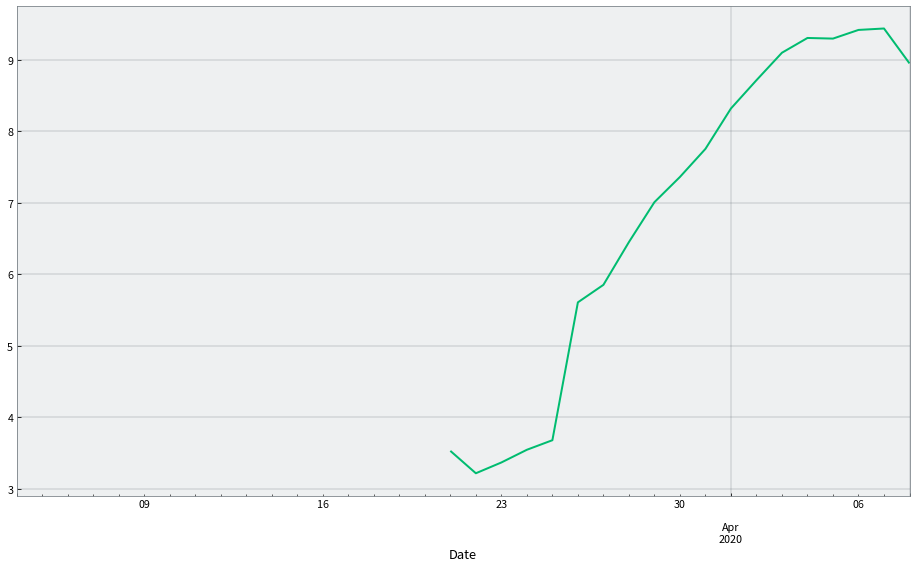

In [172]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100).plot(kind='line')

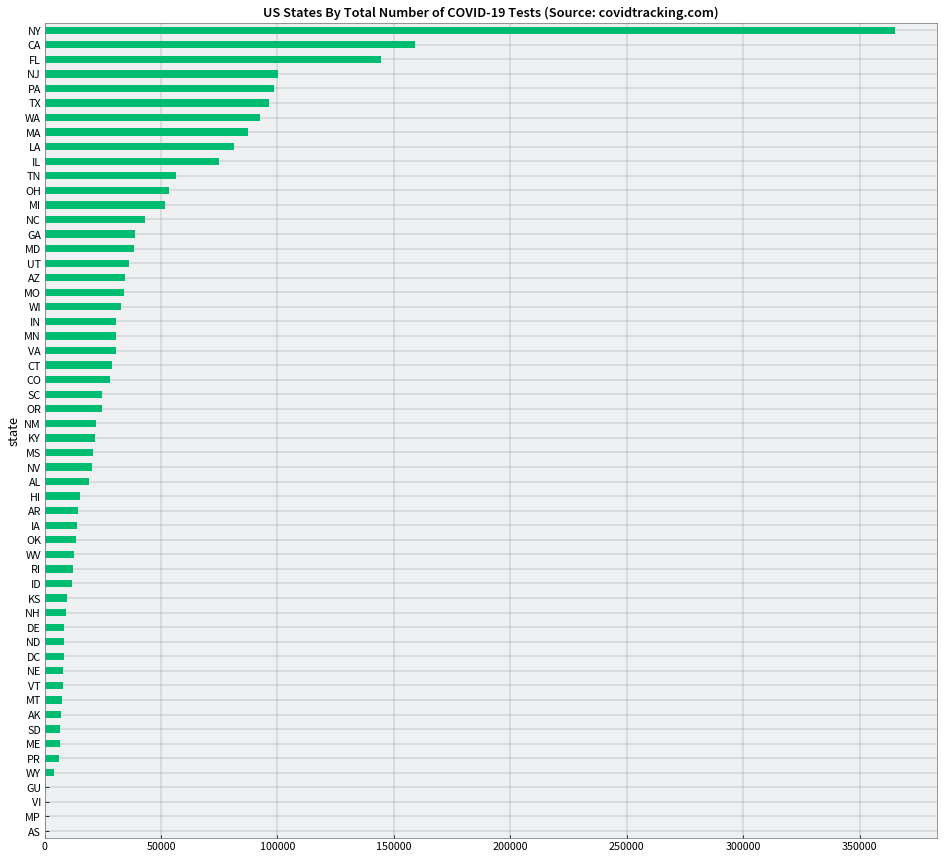

In [173]:
figsize(16,15)
tests_df.groupby('state')['total'].max().sort_values().plot(kind='barh',
                                                            title="US States By Total Number of COVID-19 Tests (Source: covidtracking.com)")

In [174]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values()

state
AS        1.176471
MP        2.235294
VI       16.529412
GU       31.411765
WY      211.882353
ME      251.294118
PR      275.294118
SD      352.176471
AK      358.823529
MT      365.941176
VT      387.705882
DC      425.176471
ND      427.294118
NE      444.529412
NH      466.117647
DE      497.882353
KS      531.352941
ID      628.294118
RI      653.941176
WV      714.588235
OK      741.705882
IA      744.764706
AR      803.176471
HI      872.823529
NM     1027.411765
AL     1030.588235
NV     1054.588235
MS     1136.117647
KY     1178.411765
OR     1267.000000
SC     1351.352941
CO     1384.941176
CT     1525.647059
MN     1533.705882
WI     1544.470588
VA     1606.352941
IN     1727.941176
UT     1907.470588
MO     1979.470588
AZ     2007.647059
GA     2045.117647
NC     2149.941176
MD     2242.588235
MI     2859.058824
TN     3108.294118
OH     3108.823529
WA     3819.235294
IL     3926.235294
LA     4582.823529
MA     4788.588235
TX     5147.176471
PA     5476.176471
NJ    

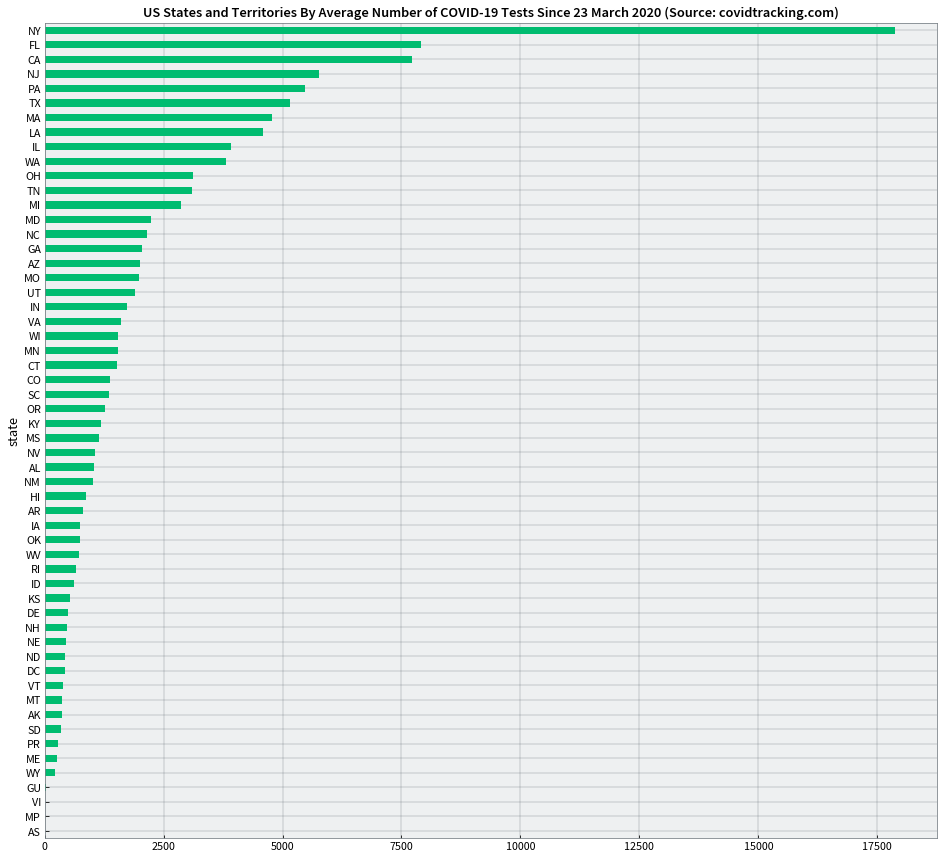

In [175]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values().plot(kind='barh',
                                                                                                                  title="US States and Territories By Average Number of COVID-19 Tests Since 23 March 2020 (Source: covidtracking.com)")

In [176]:
tests_df.groupby('state')['positive'].max().sort_values()

state
AS         0.0
MP        11.0
VI        45.0
GU       125.0
WY       221.0
AK       226.0
ND       251.0
MT       332.0
SD       393.0
HI       410.0
WV       462.0
NE       519.0
ME       537.0
VT       605.0
PR       620.0
NH       788.0
NM       794.0
KS       900.0
DE       928.0
AR      1000.0
IA      1145.0
KY      1149.0
MN      1154.0
ID      1210.0
OR      1239.0
DC      1440.0
RI      1450.0
OK      1524.0
UT      1846.0
MS      2003.0
NV      2318.0
AL      2369.0
SC      2552.0
AZ      2726.0
WI      2756.0
MO      3327.0
NC      3426.0
VA      3645.0
TN      4362.0
OH      5148.0
CO      5429.0
MD      5529.0
IN      5943.0
CT      7781.0
WA      9097.0
TX      9353.0
GA      9901.0
IL     15078.0
FL     15455.0
PA     16239.0
MA     16790.0
CA     16957.0
LA     17030.0
MI     20346.0
NJ     47437.0
NY    149316.0
Name: positive, dtype: float64

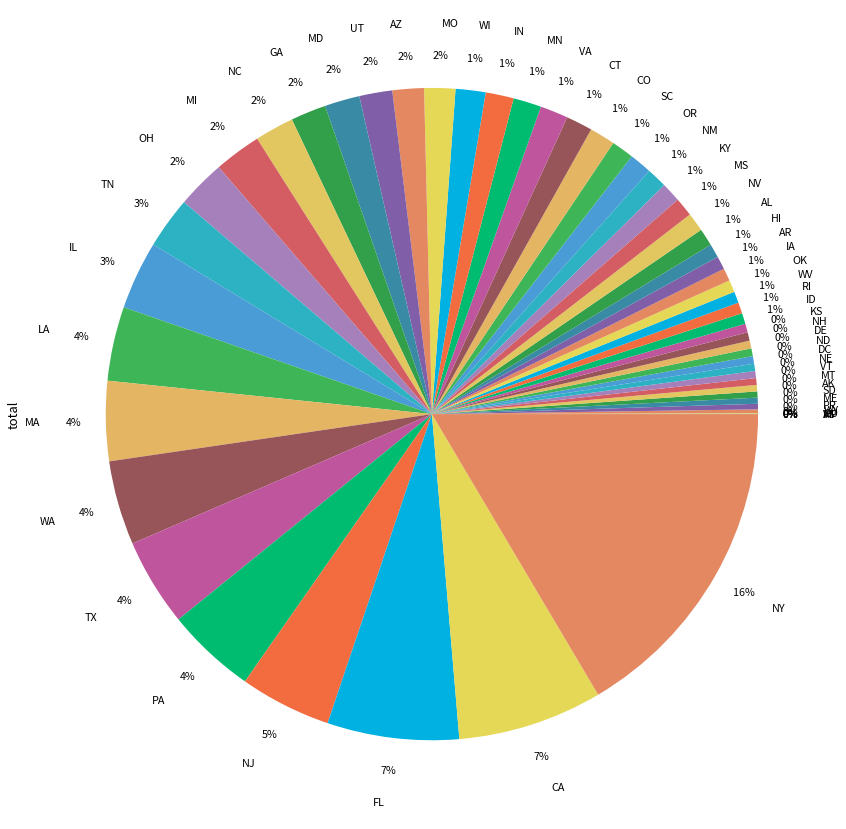

In [177]:
tests_df.groupby('state')['total'].max().sort_values().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,)

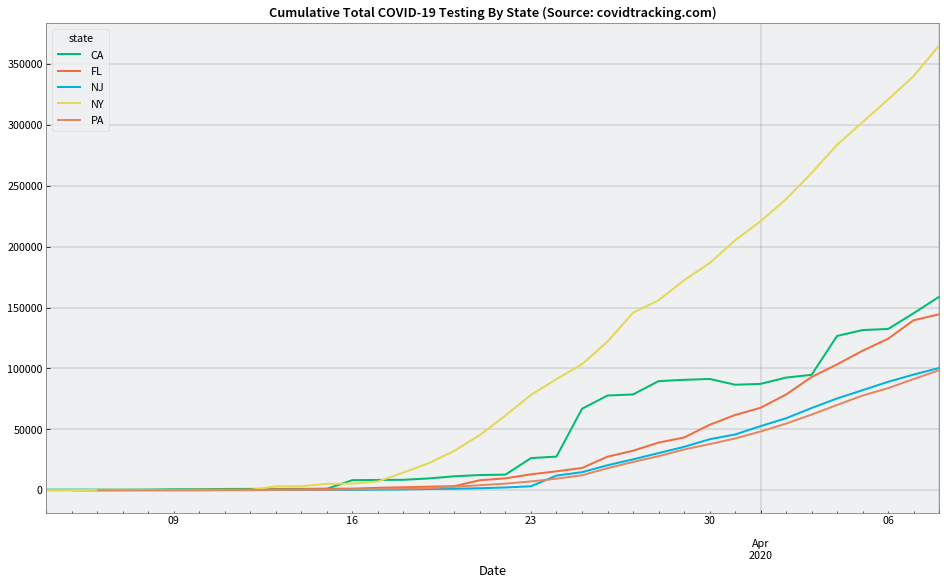

In [178]:
figsize(16, 9)
tests_df[tests_df['state'].isin(tests_df.groupby('state')['total'].max().sort_values()[-5:].index)].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                                                                     title="Cumulative Total COVID-19 Testing By State (Source: covidtracking.com)")

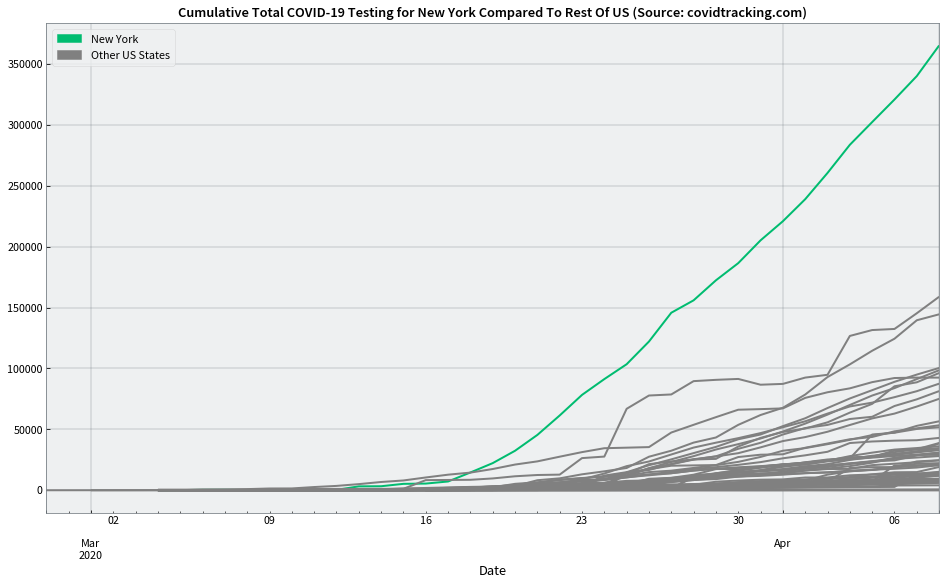

In [179]:


figsize(16, 9)
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                         title="Cumulative Total COVID-19 Testing for New York Compared To Rest Of US (Source: covidtracking.com)")

tests_df[-(tests_df['state'] == 'NY')].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                       color="gray",
                                                                                                       legend=False,
                                                                                                       ax=ax)

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#00bc70", label="New York"),
                   mpatches.Patch(color="gray", label="Other US States")])

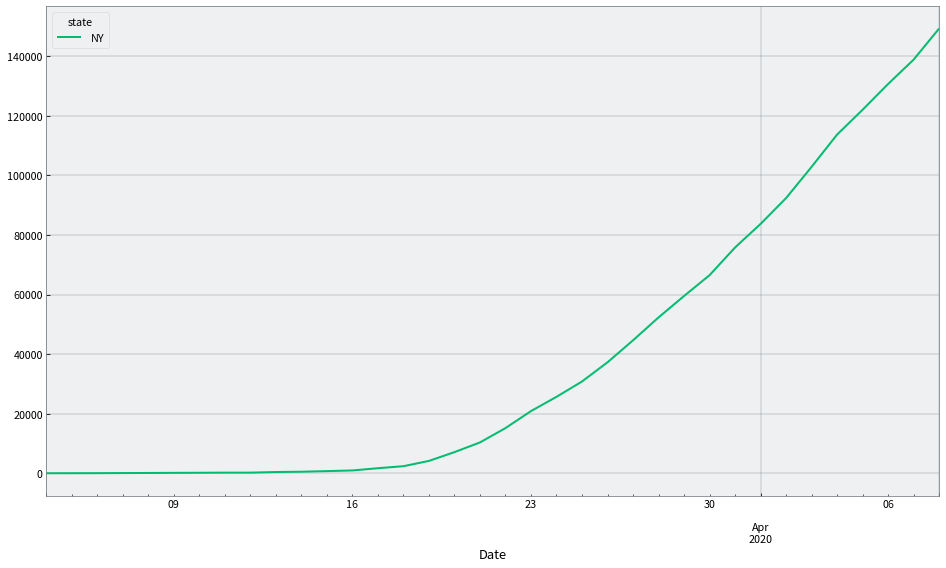

In [180]:
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests")

In [181]:
ny_state_hospitalization['Cumulative Hospitalized'] = 

SyntaxError: invalid syntax (<ipython-input-181-cc48b835a970>, line 1)

In [ ]:
tests_df['New York?'] = tests_df['state'].str.contains('NY')

In [ ]:
ax = tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,
                                                       title="Distribution of COVID-19 Testing - New York vs. Rest of the United States (Source: covidtracking.com)",
                                                       labels=['Rest of US', 'New York'])

In [ ]:
tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum()

In [ ]:
tests_df.groupby(['Date', 'New York?'])['total'].sum().unstack('New York?').diff()

In [ ]:
tests_df[tests_df['state'] == 'NY'].groupby('Date')['death'].sum().diff().plot(kind='line')

In [138]:
tests_df['Date'].max()

Timestamp('2020-04-08 00:00:00')